# Data Preprocessing

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, confusion_matrix

import re
import datetime

2023-12-03 14:54:44.777192: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 14:54:44.779418: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:54:44.822189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:54:44.823104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 14:54:45.585214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Read Data

In [2]:
links = pd.read_csv("ml-latest-small/links.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

Prepare dataset

In [3]:
# Merge tags and ratings
tags_ratings = pd.merge(tags, ratings, on=['userId','movieId'], how='outer', suffixes=('_tags', ' '))
# # Drop columns that contain _rating
tags_ratings = tags_ratings.drop(columns=['timestamp_tags'])

# Merge tags_ratings and movies
data = pd.merge(tags_ratings, movies, on=['movieId'], how='outer', suffixes=(' ', '_movie'))
# Rename timestamp column as timestamp
data = data.rename(columns={'timestamp ': 'timestamp'})
# Change column order
data = data[["movieId","userId", "title", "rating","genres" ,"tag","timestamp"]]
# Drop rows with NaN timestamp
data = data.dropna(subset=["timestamp"])
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')

0        2015-10-24 22:29:40
1        2015-10-24 22:29:40
2        2015-10-24 22:29:40
3        2018-06-14 02:59:36
4        2018-06-14 02:59:36
                 ...        
102879   2016-11-19 11:55:49
102880   2016-11-19 11:43:18
102881   2017-05-03 23:53:14
102882   2017-05-04 00:59:49
102883   2017-05-04 01:22:35
Name: timestamp, Length: 102677, dtype: datetime64[ns]

In [4]:
# tagratings = pd.pivot_table(data, values=['rating'], columns=['tag'], aggfunc='mean')
# tagratings

In [5]:
data['rating'] = data['rating'].apply(lambda x: 1 if x > 3 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x) if x is not np.nan else np.nan)
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x) if x is not np.nan else np.nan)
data['tag'] = data['tag'].str.lower()

In [6]:
data["rating"].value_counts()

rating
1    63364
0    39313
Name: count, dtype: int64

# Model Development

In [7]:
filled_tags = data.dropna(subset=['tag'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filled_tags['tag'])
sequences = tokenizer.texts_to_sequences(filled_tags['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Found 1730 unique tokens.


In [8]:
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = filled_tags['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names_out()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

number of words in plot summary:  1657


In [9]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


## K-Means

In [10]:
reduced_data = PCA(n_components=2).fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

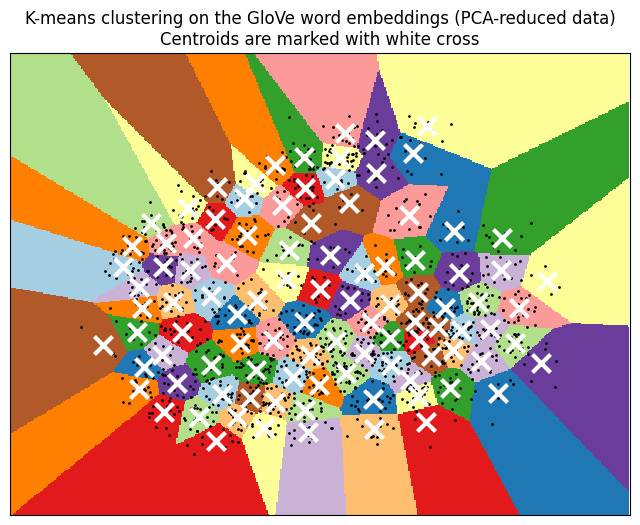

In [11]:
plt.figure(figsize=(8, 6))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

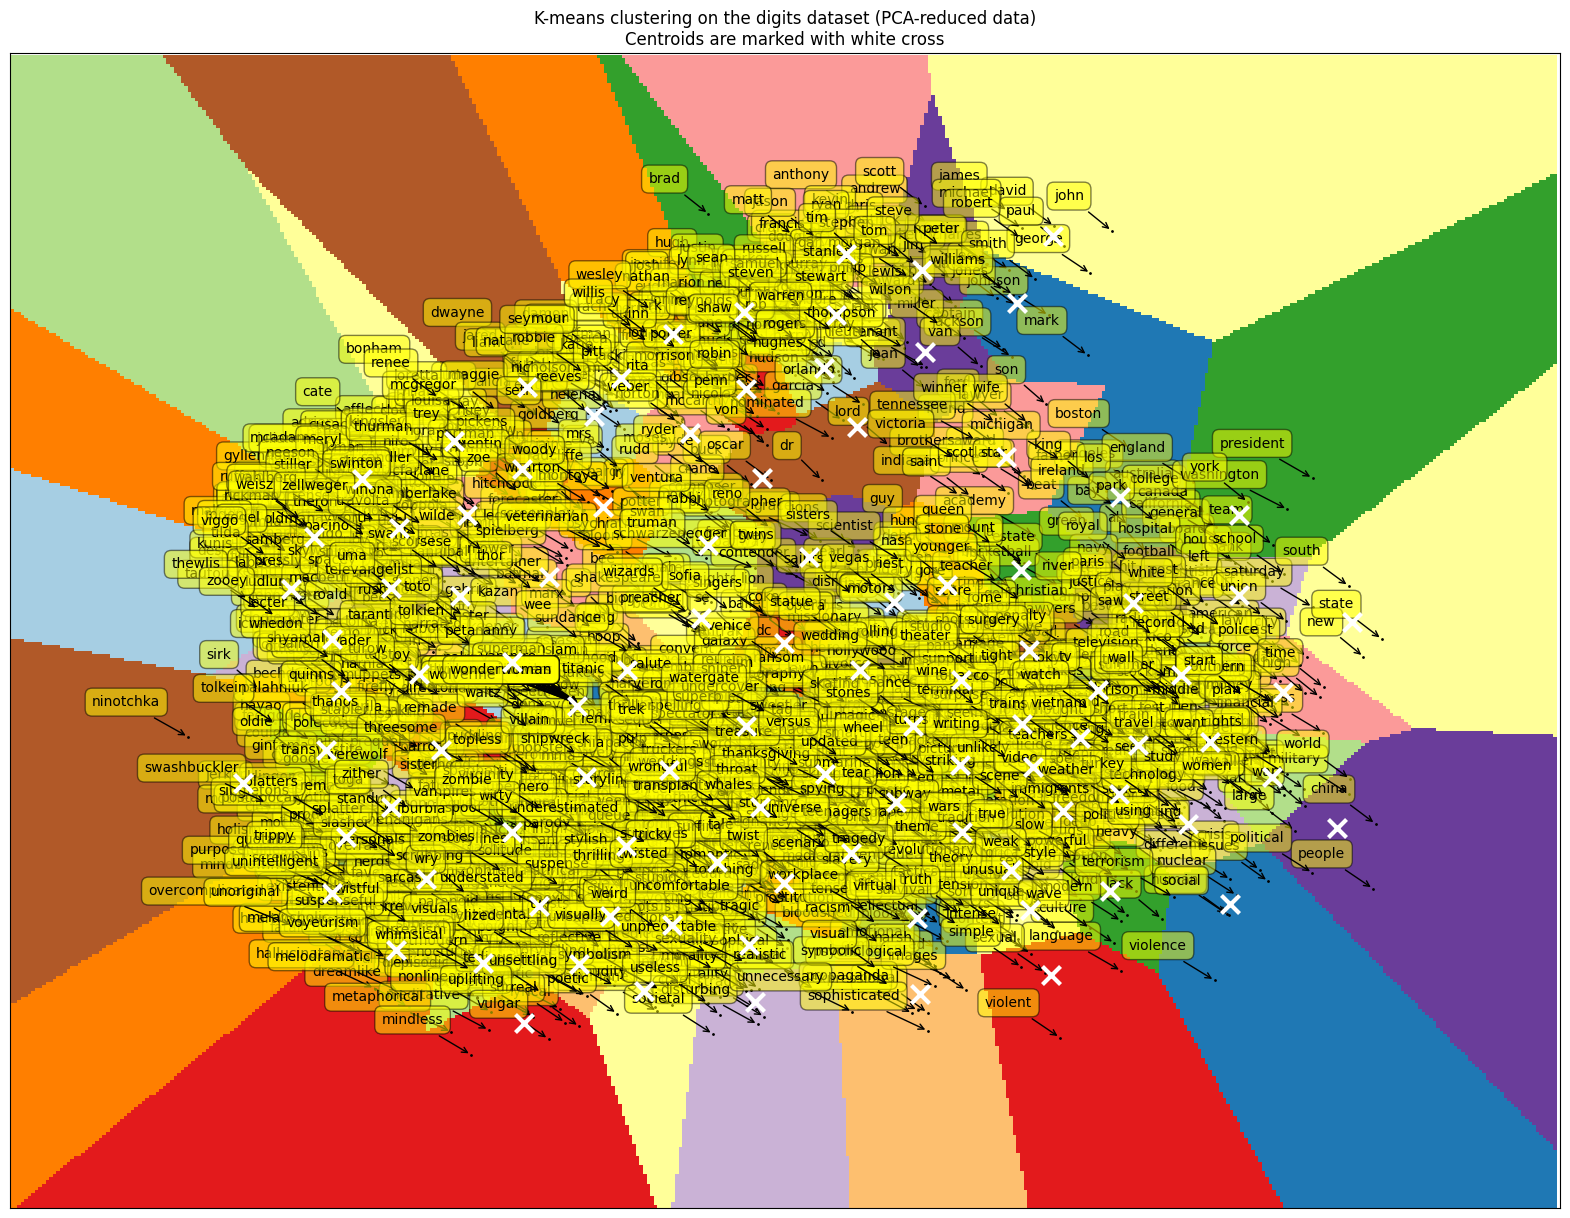

In [12]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Random Forest

In [13]:
# Cluster word embeddings data
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdwordvec.T)
# Get cluster labels
clusters = kmeans.labels_


# Create a dictionary to store columns for each cluster
cluster_columns = {str(i): [0] * len(data) for i in range(max(clusters) + 1)}

# Update the dictionary values based on word-cluster associations
for i, column in enumerate(pdwordvec.columns):
    indices = pdwordvec.index[pdwordvec[column] > 0]
    cluster_columns[str(clusters[i])] = [1 if idx in indices else val for idx, val in enumerate(cluster_columns[str(clusters[i])])]

# Create a DataFrame from the cluster columns dictionary
cluster_df = pd.DataFrame(cluster_columns)

# Concatenate the cluster columns to the 'data' DataFrame
data = pd.concat([data, cluster_df], axis=1)


# # Create a dictionary to store columns for each cluster
# cluster_columns = {str(i): [0] * len(data) for i in range(max(clusters) + 1)}

# # Update the dictionary values based on word-cluster associations
# for i, column in enumerate(pdwordvec.columns):
#     indices = pdwordvec.index[pdwordvec[column] > 0]
#     cluster_columns[str(clusters[i])] = [1 if idx in indices else val for idx, val in enumerate(cluster_columns[str(clusters[i])])]

# # Update 'data' DataFrame with the new columns
# for col, values in cluster_columns.items():
#     data[col] = values

In [14]:
data

,movieId,userId,title,rating,genres,tag,timestamp,0,1,2,...,290,291,292,293,294,295,296,297,298,299
0,60756.0,2.0,Step Brothers (2008),1.0,Comedy,funny,2015-10-24 22:29:40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60756.0,2.0,Step Brothers (2008),1.0,Comedy,highly quotable,2015-10-24 22:29:40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60756.0,2.0,Step Brothers (2008),1.0,Comedy,will ferrell,2015-10-24 22:29:40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60756.0,62.0,Step Brothers (2008),1.0,Comedy,comedy,2018-06-14 02:59:36,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60756.0,62.0,Step Brothers (2008),1.0,Comedy,funny,2018-06-14 02:59:36,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Drop tag as we will use vectorized words
# data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Reset index of genresplit
genresplit = genresplit.reset_index()

#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Joın data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)

In [16]:
data = data.fillna(np.nan)
data = data.dropna(subset=["title"])

## ML Classification Models

In [17]:
train = data[(data['timestamp'] < '2017-05-01') ]
test = data[(data['timestamp'] >= '2017-05-01') ]

print("len test data set:", len(test))
print("len training data set:",len(train))

len test data set: 13502
len training data set: 89175


In [18]:
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating','genres','tag','timestamp','title'], axis=1)
x_test = test.drop(['rating','genres','tag','timestamp','title'], axis=1)

# # Set x_train and x_test to have only numeric columns
# x_train = x_train.select_dtypes(include=[np.number])
# x_test = x_test.select_dtypes(include=[np.number])

In [19]:
baselineaccuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print("Accuracy of the baseline model is: ", np.round(baselineaccuracy,2))

Accuracy of the baseline model is:  0.59


In [20]:
x_train.fillna(0, inplace=True)
x_test.fillna(0, inplace=True)

In [21]:
x_train["5"].value_counts()

5
0.0    89166
1.0        9
Name: count, dtype: int64

In [23]:
RFC = RandomForestClassifier(class_weight='balanced')
RFC.set_params(n_estimators=10)
RFC.fit(x_train, y_train)

y_pred = RFC.predict(x_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy",np.round(accuracy, 2))
print("\nRecall: ", np.round(recall, 2))
print("Precision: ", np.round(precision, 2))
print("F1 Score: ", np.round(f1, 2))


Confusion Matrix:
[[1286 4293]
 [ 929 6994]]
Accuracy 0.61

Recall:  0.88
Precision:  0.62
F1 Score:  0.73


In [25]:
depth = range(2, 55, 5)

train_acc = []
test_acc = []

for i in depth:
    RFC.set_params(n_estimators=10, max_depth=i)
    RFC.fit(x_train, y_train)
    train_acc.append(RFC.score(x_train, y_train))
    test_acc.append(RFC.score(x_test, y_test))

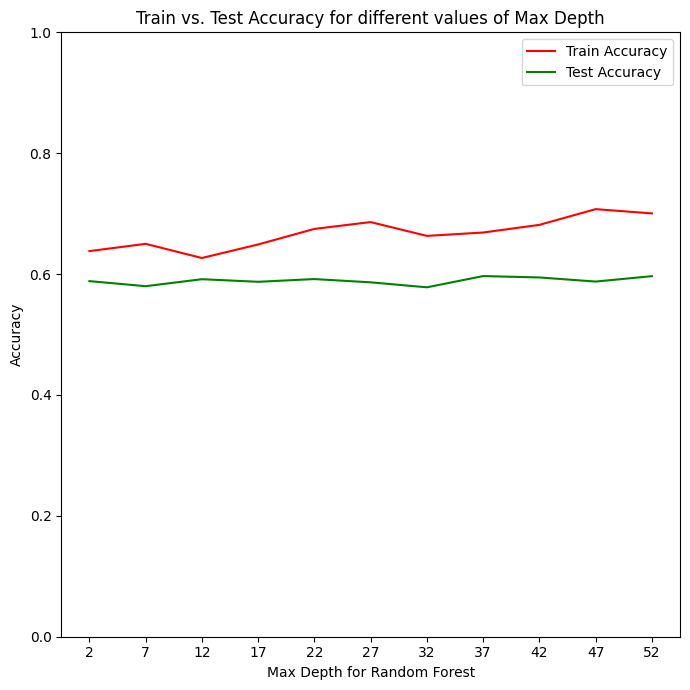

Accuracy is maximum at max depth value of 37 and yields accuracy of 0.6


In [26]:
#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(11), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 2))

In [27]:
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)

userid_298.0        0.057162
userid_307.0        0.044990
userid_19.0         0.031233
userid_217.0        0.027339
userid_368.0        0.022506
                      ...   
movieid_6162.0      0.000000
movieid_6159.0      0.000000
movieid_6158.0      0.000000
movieid_6156.0      0.000000
movieid_193609.0    0.000000
Name: Importance, Length: 10653, dtype: float64

In [28]:
importance[importance['Importance']==0].count()

Importance    7000
Std           7000
dtype: int64